<a href="https://colab.research.google.com/github/FatimaZohraBoumhaout/Occlusion/blob/main/Occlusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

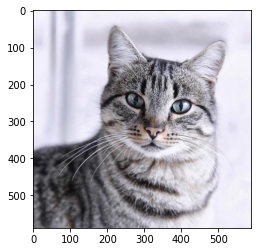

Image type: torch.FloatTensor
Image size: torch.Size([3, 588, 588])


In [ ]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
%matplotlib inline

# function to convert PIL images to tensors.
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()

# Read the image from file.
image = Image.open('/content/Tabby-cat-3.jpg')
rgb_image = pil2tensor(image)

# Plot the image here using matplotlib.
def plot_image(tensor):
    plt.figure()
    # imshow needs a numpy array with the channel dimension
    # as the the last dimension so we have to transpose things.
    plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.show()

plot_image(rgb_image)

# Show the image tensor type and tensor size here.
print('Image type: ' + str(rgb_image.type()))
print('Image size: ' + str(rgb_image.size()))


In [ ]:
!git clone https://github.com/ruthcfong/pytorch_workflow

Cloning into 'pytorch_workflow'...
remote: Enumerating objects: 200, done.
remote: Total 200 (delta 0), reused 0 (delta 0), pack-reused 200
Receiving objects: 100% (200/200), 66.87 KiB | 11.14 MiB/s, done.
Resolving deltas: 100% (105/105), done.


In [ ]:
!rm -rf pytorch_workflow

In [ ]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
IMAGENET_MU = [0.485, 0.456, 0.406]
IMAGENET_SIGMA = [0.229, 0.224, 0.225]


class NormalizeInverse(transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super(NormalizeInverse, self).__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super(NormalizeInverse, self).__call__(tensor.clone())


class Clip(object):
    """Pytorch transformation that clips a tensor to be within [0,1]"""
    def __init__(self):
        return

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): tensor to be clipped.
        Returns:
            Tensor: clipped tensor.
        """
        t = tensor.clone()
        t[t > 1] = 1
        t[t < 0] = 0
        return t


def get_detransform(mu=IMAGENET_MU, sigma=IMAGENET_SIGMA):
    detransform = transforms.Compose([
        NormalizeInverse(mu, sigma),
        Clip(),
        # transforms.ToPILImage(),
    ])
    return detransform


In [ ]:
convert_tensor = transforms.ToTensor()

size = (224, 224)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std) # (x - mean) / std
])

# x = convert_tensor(image)

x = transform(image)

In [ ]:
detransform = get_detransform()

In [ ]:
mask = torch.ones(1,224,224)
mask[-1,40:150,40:150] = 0

In [ ]:
x.shape

torch.Size([3, 224, 224])

In [ ]:
masked_x = x * mask

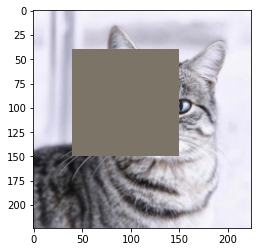

In [ ]:
plot_image(detransform(masked_x))

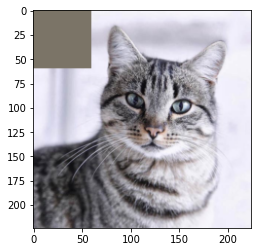

j: 0


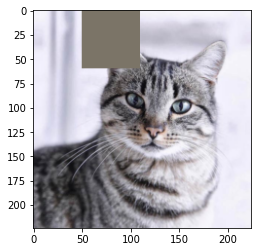

j: 50


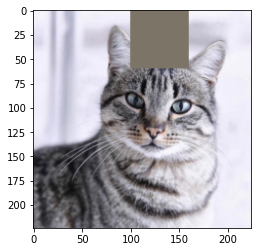

j: 100


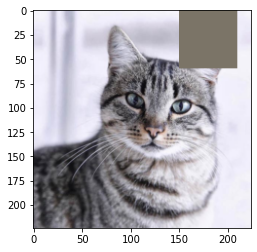

j: 150


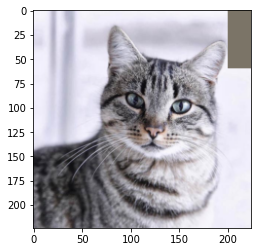

j: 200
i:0


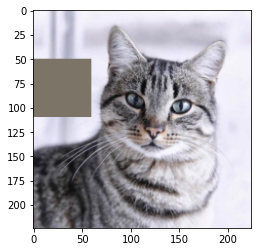

j: 0


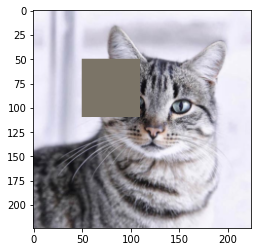

j: 50


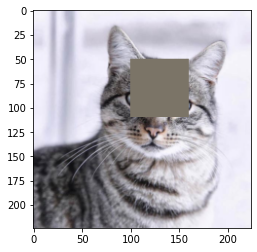

j: 100


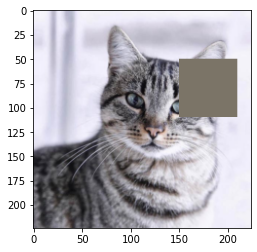

j: 150


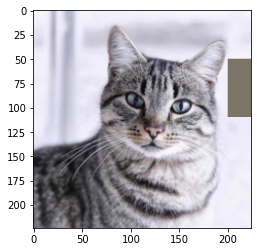

j: 200
i:50


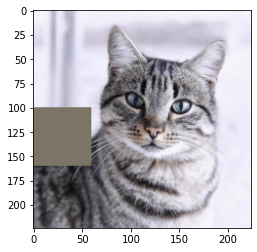

j: 0


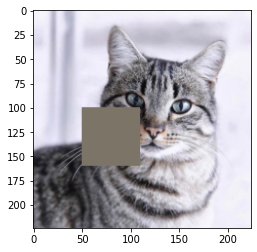

j: 50


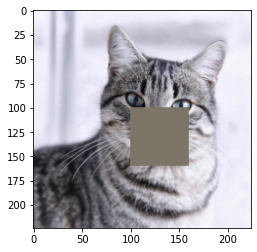

j: 100


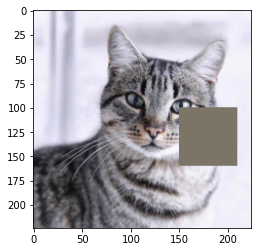

j: 150


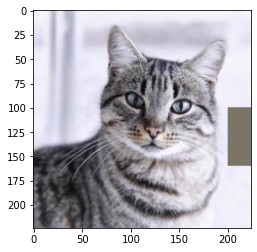

j: 200
i:100


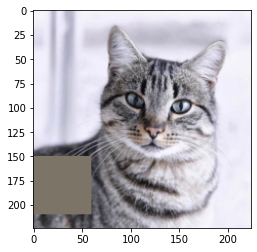

j: 0


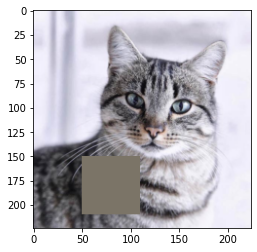

j: 50


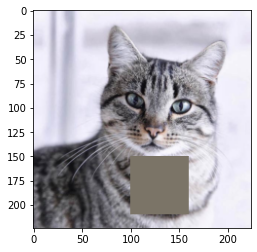

j: 100


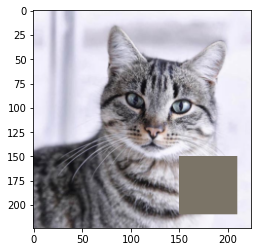

j: 150


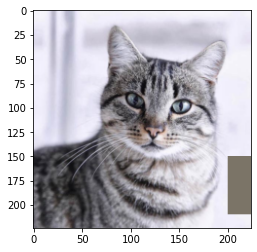

j: 200
i:150


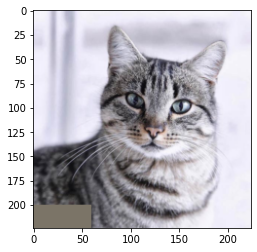

j: 0


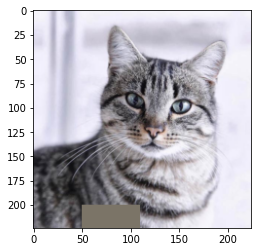

j: 50


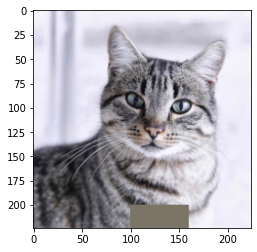

j: 100


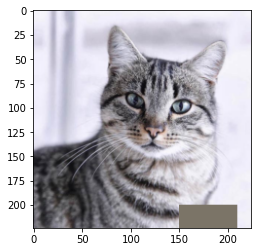

j: 150


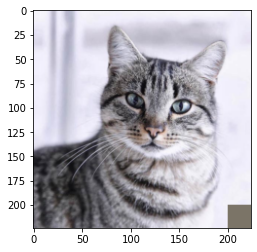

j: 200
i:200


In [ ]:
# Sliding the gray square
def sliding(stride, size, img):
  _, x, y = img.size()
  for i in range(0,x,stride):
    for j in range(0, y, stride):
      mask = torch.ones(1,224,224)
      mask[-1,i:i+size,j:j+size] = 0
      masked_img = img * mask
      plot_image(detransform(masked_img))
      print(f"j: {j}")
    print(f"i:{i}")

sliding(50, 60, x)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


torch.Size([224, 224])


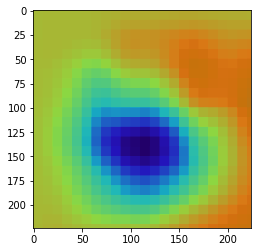

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def heat_map_gen(img, size, stride, model):
  
  _, x, y = img.size()
  mask_sum = torch.zeros(3, x, y)
  sum = torch.zeros(3,x,y)
  # loop for each occlusion
  for i in range(0,x,stride):
    for j in range(0, y, stride):
      mask = torch.ones(1,x,y)
      mask[-1,i:i+size,j:j+size] = 0
      masked_img = img * mask
      # update masked image and mask
      with torch.no_grad():
        y_output = model(masked_img.unsqueeze(0))
      # print(y_output, y_output.shape)
      sum += y_output[0][280] * mask
      mask_sum += mask
  # plot heat map
  heat_map_tensor = 0.25*torch.divide(sum, mask_sum)
  heat_map_single = heat_map_tensor[0][:][:]
  print(heat_map_single.shape)
  # heat_map= heat_map_tensor.permute(1, 2, 0)

  plt.imshow(heat_map_single)
  plt.imshow(heat_map_single, cmap='jet', alpha=0.5) 
  # plt.imshow(heat_map)
  # print(heat_map_tensor)
  # return heat_map
  


model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model.eval()
heat_map = heat_map_gen(x, 100, 10, model)

In [ ]:
from PIL import Image
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)